In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
data = pd.read_excel("MarketDATA.xlsx")

In [3]:
data.head()

,Date,Crop,Market_Price,Production_Cost,Gross_Profit_Margin
0,2022-01-01,Cabbage,24.85,7.17,71.17
1,2022-02-01,Cabbage,23.90,8.37,65.00
2,2022-03-01,Cabbage,31.78,5.77,81.85
3,2022-04-01,Cabbage,22.32,7.14,68.02
4,2022-05-01,Cabbage,32.12,6.61,79.43


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data1 = data.sort_index()

In [5]:
# Encode the Crop column
label_encoder = LabelEncoder()
data['Crop_encoded'] = label_encoder.fit_transform(data['Crop'])

In [6]:
data.head(5)

,Crop,Market_Price,Production_Cost,Gross_Profit_Margin,Crop_encoded
Date,,,,,
2022-01-01,Cabbage,24.85,7.17,71.17,23
2022-02-01,Cabbage,23.90,8.37,65.00,23
2022-03-01,Cabbage,31.78,5.77,81.85,23
2022-04-01,Cabbage,22.32,7.14,68.02,23
2022-05-01,Cabbage,32.12,6.61,79.43,23


In [7]:
scaler = MinMaxScaler()
data[['Market_Price', 'Production_Cost','Crop_encoded']] = scaler.fit_transform(
    data[['Market_Price', 'Production_Cost','Crop_encoded']]
)

In [8]:
data.head(100)

,Crop,Market_Price,Production_Cost,Gross_Profit_Margin,Crop_encoded
Date,,,,,
2022-01-01,Cabbage,0.630875,0.511628,71.17,0.140244
2022-02-01,Cabbage,0.599869,0.607859,65.00,0.140244
2022-03-01,Cabbage,0.857050,0.399358,81.85,0.140244
2022-04-01,Cabbage,0.548303,0.509222,68.02,0.140244
2022-05-01,Cabbage,0.868146,0.466720,79.43,0.140244
...,...,...,...,...,...
2023-12-01,Carrots,0.833225,0.769848,66.55,0.158537
2024-01-01,Carrots,0.422977,0.432237,66.57,0.158537
2024-02-01,Carrots,0.788838,0.520449,75.49,0.158537


In [9]:
data1 = data.drop(columns=['Crop'])

In [10]:
data1.head()

,Market_Price,Production_Cost,Gross_Profit_Margin,Crop_encoded
Date,,,,
2022-01-01,0.630875,0.511628,71.17,0.140244
2022-02-01,0.599869,0.607859,65.00,0.140244
2022-03-01,0.857050,0.399358,81.85,0.140244
2022-04-01,0.548303,0.509222,68.02,0.140244
2022-05-01,0.868146,0.466720,79.43,0.140244


In [11]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)


In [12]:
# Define noise function
def add_noise(data, noise_factor=0.01):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    return noisy_data

scaler = MinMaxScaler()

crops = data1['Crop_encoded'].unique()  # Get unique crops

all_sequences = []
all_targets = []

for crop in crops:
    # Filter data by crop and drop 'Crop_encoded'
    crop_data = data1[data1['Crop_encoded'] == crop].drop('Crop_encoded', axis=1)
    
    # Ensure that the crop data has at least 12 rows for sequence creation
    if len(crop_data) >= 12:
        # Scale the crop data
        scaled_crop_data = scaler.fit_transform(crop_data)
        
        # Add noise to the scaled data
        noisy_data = add_noise(scaled_crop_data, noise_factor=0.01)  # Adjust noise_factor as needed
        
        # Create sequences and targets (12-month sequences)
        sequences, targets = create_sequences(noisy_data, sequence_length=12)
        
        # Append the sequences and targets
        all_sequences.append(sequences)
        all_targets.append(targets)

# Combine the list of sequences and targets into numpy arrays
X = np.concatenate(all_sequences)
y = np.concatenate(all_targets)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (3996, 12, 3), Shape of y: (3996, 3)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [15]:
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential()

# First LSTM layer
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(BatchNormalization())  # Batch Normalization to stabilize training

# Second LSTM layer
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Third LSTM layer
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(y_train.shape[1]))  # Adjust to match your target output shape

# Compile the model with a lower learning rate for the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Learning rate scheduler to reduce the learning rate if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1)



/home/ghost/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,275 (508.89 KB)

 Trainable params: 129,891 (507.39 KB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[lr_scheduler])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.2066 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0743 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0658 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0648 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0604 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0613 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0581 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0586 - learning_rate: 0.0010
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0574 - learning_rate: 0.0010
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0560 - learning_rate: 0.0010
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.056

In [18]:
model.save("marketlstm.h5")

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math


In [21]:
# Generate predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)

# Compute RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Compute R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Squared Error (MSE): 0.04824530681230935
Root Mean Squared Error (RMSE): 0.21964814320250775
R-squared (R²): 0.2087127668660145


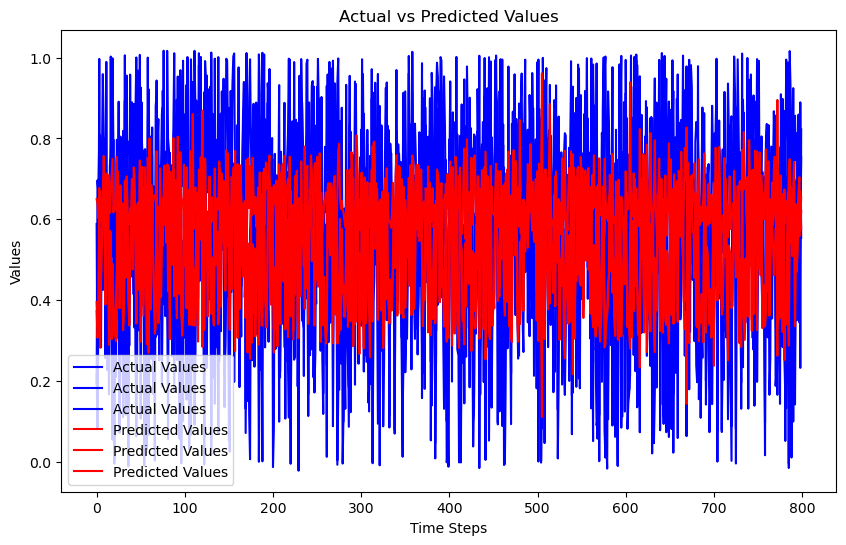

In [22]:
plt.figure(figsize=(10, 6))

# Plot predicted vs actual values
plt.plot(y_test, label='Actual Values', color='b')
plt.plot(y_pred, label='Predicted Values', color='r')

# Labels and Title
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [39]:
# # Compute residuals
# residuals = y_test - y_pred

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(residuals)), residuals, color='purple')
# plt.axhline(y=0, color='black', linestyle='--')

# # Labels and Title
# plt.title('Residuals (Errors)')
# plt.xlabel('Time Steps')
# plt.ylabel('Residuals')

# # Show the plot
# plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding dropout to reduce overfitting
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))  # Output layer for regression

optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='mse')

# Fit the model with a validation set
# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[lr_scheduler])


In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)

# Compute RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Compute R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')
